In [250]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [269]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [270]:
len(words)

32033

In [271]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [272]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [273]:
Ytr[Xtr.sum(1) == 0].unique(return_counts=True)

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26]),
 tensor([3545, 1024, 1198, 1350, 1260,  338,  550,  705,  482, 1921, 2395, 1255,
         2001,  911,  315,  408,   74, 1326, 1650, 1016,   59,  295,  259,  109,
          416,  764]))

In [303]:
embedding_size = 10
hl_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedding_size), generator=g)
W1 = torch.randn((embedding_size * block_size, hl_size), generator=g)
b1 = torch.randn(hl_size, generator=g)
W2 = torch.randn((hl_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [304]:
sum(p.nelement() for p in parameters)

11897

In [305]:
for p in parameters:
    p.requires_grad = True

In [306]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [307]:
for i in range(200000):
    # minibatching
    ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)

    # forward pass
    emb = C[Xtr[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())

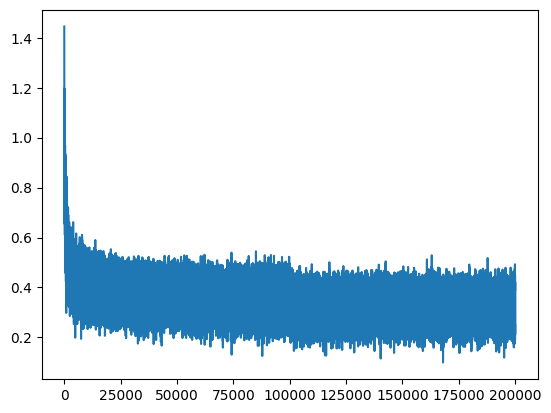

In [308]:
plt.plot(stepi, lossi)

In [309]:
emb = C[Xtr] # [32, 3, 2]
h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1) # [32, 100]
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1218, grad_fn=<NllLossBackward0>)

In [310]:
emb = C[Xdev] # [32, 3, 2]
h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1) # [32, 100]
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1626, grad_fn=<NllLossBackward0>)

In [311]:
g = torch.Generator().manual_seed(4)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

bran.
averly.
aperya.
ashfi.
eina.
heylonne.
gio.
shawnixxavyoon.
fred.
nicanasteya.
holthangen.
mikayscotez.
kaya.
eklin.
alham.
nys.
fexfon.
maxshan.
darily.
jalmully.
